# Project 1 -- Radiation and SEDs

In this project, we will play with the Planck function and revisit our protoplanetary disk. Q1,2 adapted from Zach Berta-Thompson.

We'll be making use of python functions in the project. Functions are blocks of code that execute when called; they can be defined in a cell in a python notebook (in which case you have to run the cell to define the function) or defined in another file (in which case you have to import them). We can pass variables into a function so that, for example, we can use one function to calculate flux for any temperature blackbody we want.

In [1]:
import matplotlib.pyplot as plt 
import numpy as np
from astropy import units, constants
from scipy.integrate import simps
import pandas as pd

plt.matplotlib.rcParams['figure.figsize'] = (10,7)
plt.matplotlib.rcParams['font.size'] = 12
%matplotlib inline

### Q1: 

The Planck function expresses the *intensity* from a thermal emitting source. In terms of wavelength (in a form that can be integrated against $d\lambda$), it can be written as 

$$B_{\lambda}(\lambda, T) = \frac{{2hc}^2}{\lambda^5}\frac{1}{e^{hc/\lambda k_BT} - 1}$$

and has SI units that are equivalent to $J~{s}^{-1}~{m}^{-2}~{sr}^{-1}~{\mu m}^{-1}$. (Note that the  ${\mu m}^{-1}$ in refers to the width of the wavelength range $d\lambda$ -- something you'll see $m$, $nm$, $angstrom$, or other units instead.)

I've defined almost the whole function below, but carefully look through each step and make sure you know what's going on.

+ Fill in the missing line to calculate the flux from intensity

In [2]:
def planck_intensity(wavelength, temperature):
    '''
    This function calculates the intensity of thermal emission
    of a surface.
    '''
    
    # define variables as shortcut to the constants we need
    h = constants.h
    k = constants.k_B
    c = constants.c

    # this is the thing that goes into the exponent (it's units better cancel!)
    u = h*c/(wavelength*k*temperature)    
    
    intensity = (2*h*c**2/wavelength**5/(np.exp(u) - 1))/units.steradian
    return intensity.to('erg/(s*cm**2*micron*steradian)')

def planck_flux(wavelength, temperature):
    '''
    This function calculates the thermal emission spectrum of a surface.
    
        Inputs:
            wavelength = numpy array of wavelengths (in nm)
            temperature = a single number, the temperature (in K)
    
        Outputs:
            Returns an array of thermal emission fluxes,
            in units of erg/(s*cm^2*micron). This is a flux, which has 
            already been integrated over solid angle.
    '''

    # calculate the intensity from the Planck function
    # FILL IN MISSING LINE OF FUNCTION HERE
    intensity = planck_intensity(wavelength, temperature)

    # calculate the flux, assuming isotropic radiation (as in R&L)
    flux = np.pi * intensity * units.sr
    
    # return the flux, in convenient units
    return flux.to('erg/(s*cm**2*micron)')

+ Make a plot of $\lambda$ vs. $F_\lambda(\lambda, T=300~K)$, covering $1-100~\mu m$. Wien's Law states that the peak of this spectrum will be at $\lambda_{\rm max} = b/T$, with $b = 2900~\mu m~K$. (The first two lines have been completed for you)

+ To make sure you have your horizontal axis lined up appropriately, plot a vertical line at this predicted peak location.

In [3]:
# specify a temperature
T = 300*units.K

# create a grid of wavelengths (with units)
w = np.logspace(0, np.log10(100), 1000)*units.micron

Text(0.5, 1.0, 'Thermal Emission Spectrum at T = 300 K')

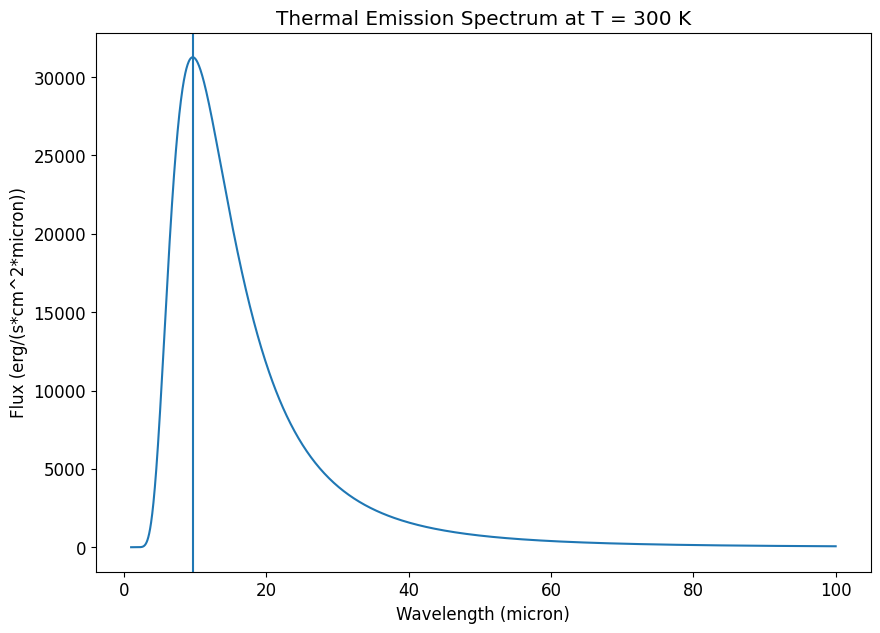

In [4]:
plt.plot(w, planck_flux(w, T))
plt.axvline(2900/300)
plt.xlabel('Wavelength (micron)')
plt.ylabel('Flux (erg/(s*cm^2*micron))')
plt.title('Thermal Emission Spectrum at T = 300 K')

+ The Stefan-Boltzmann Law states that the bolometric flux from a surface is
$$F_{\rm bol}(T) = \int^{\infty}_{0}F_{\lambda}(\lambda, T)d\lambda = \sigma_{\rm SB}T^4$$
in units of $erg/cm^2$. To make sure you have the units and overall scale of your Planck function correct, let's make sure we can recover this result. Numerically integrate your Planck function over wavelength, and compare it to the value from this analytic expression. (There are a couple of ways to do this numerical integral; `np.trapz` can integrate along a defined grid of $y$ and $x$, or `scipy.integrate` has tools for directly integrating a function between limits.)

In [5]:
def flux_bol(temperature):
    # wavelength grid (in microns, wide enough to capture full Planck curve)
    w = np.logspace(-3, 3, 5000) * units.micron  # 10^-3 to 10^3 microns
    
    # flux per unit wavelength
    F_lambda = planck_flux(w, temperature)  # erg / (s cm^2 micron)
    
    # integrate over wavelength to get bolometric flux
    F_bol = simps(F_lambda.value, w.value) * F_lambda.unit * w.unit
    
    return F_bol.to('erg/(s*cm^2)')

F_num = flux_bol(300*units.K)
F_SB = (constants.sigma_sb * (300*units.K)**4).to('erg/(s*cm^2)')
print("Numerical Flux:", F_num, "Stefan-Boltzmann Flux:", F_SB)

Numerical Flux: 459297.7737601295 erg / (cm2 s) Stefan-Boltzmann Flux: 459300.327953939 erg / (cm2 s)


/usr/local/Caskroom/miniconda/base/envs/a74/lib/python3.7/site-packages/astropy/units/quantity.py:486: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


### Q2: What color is a star?

When we look at a source whose spectrum is $F_\lambda(\lambda)$, our eyes are basically calculating three integrals of that spectrum over wavelength. We perceive different colors as different ratios among these three integrals. Let's write some code to approximate these integrals, so we can display spectra as colors on our computer screens. Flux integrals like these pop up [all the time](https://ui.adsabs.harvard.edu/#abs/2005ARA&A..43..293B/abstract) in astronomy, where we talk about flux through broadband photometric filters.

First, we need to know the effective response of the cones in our eyes to different wavelengths of light. We can approximate these using three "color matching functions" $\bar{x}(\lambda)$, $\bar{y}(\lambda)$, and $\bar{z}(\lambda)$.  The file `ciexyz31.txt` contains a table of these three functions. Load in these color matching functions, and use them to calculate the following three quantities:

$$X = \int F_{\lambda}(\lambda)~\bar{x}(\lambda)~d\lambda $$
$$Y = \int F_{\lambda}(\lambda)~\bar{y}(\lambda)~d\lambda $$
$$Z = \int F_{\lambda}(\lambda)~\bar{z}(\lambda)~d\lambda $$

These are integrals of the intrsinsic spectrum, weighted by the sensitivity of each "filter" to light at each wavelength. You can think of $X$, $Y$, and $Z$ roughly as the brightness of three colored lamps ("pseudo-red", "pseudo-green", "pseudo-blue") which all mix together to form the final color. However, these pseudo-colors aren't exactly the RGB ("red", "green", "blue") colors that our screens display. To get to actual RGB values, these need to be stretched and squeezed a little bit through a linear matrix transformation. The function `xyz2rgb` below handles this conversion for you. 

The final RGB color for a given spectrum should be an array of three numbers, all between 0 and 1. For example, an RGB array of `[0.0, 0.0, 1.0]` means "no brightness in R and G, and full brightness in B", so the color would appear blue. 

In [6]:
def xyz2rgb(X, Y, Z):
    '''
    This function converts CIE XYZ values into CIE RGB values.
    '''

    # normalize these, so they're all between 0 and 1
    x = X/(X+Y+Z)
    y = Y/(X+Y+Z)
    z = Z/(X+Y+Z)

    # make a single column matrix containing the x,y,z values
    xyz = np.matrix([x,y,z]).T
    
    # rgb = conversion * xyz (with matrix math)
    conversion = np.matrix([[0.41847, -0.15866, -0.082835],
                            [-0.091169, 0.25243, 0.015708],
                            [0.00092090, -0.0025498, 0.17860]])
    
    # calculate the rgb single-column matrix
    color_matrix = conversion*xyz

    # 
    color = np.array(color_matrix.T)[0]
    color = color/np.max(color)
    
    return color

+ Make a plot showing the color functions (that is, the "filter response" of your eye) so we can see what we are dealing with.

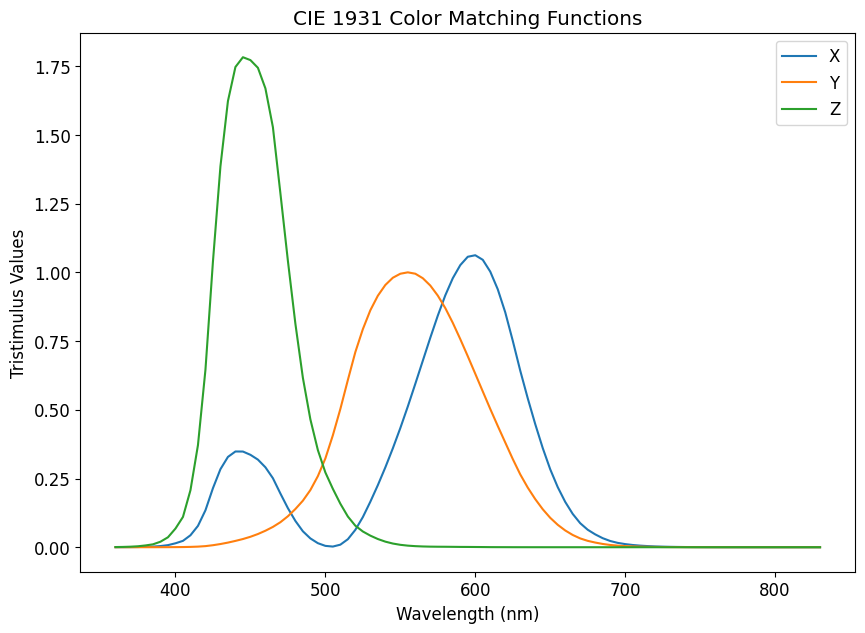

In [7]:
color_dat = pd.read_csv('ciexyz31.csv', skiprows = 5)


Lambda = color_dat['wavelength']
X = color_dat[' X']
Y = color_dat[' Y']
Z = color_dat[' Z']

plt.plot(Lambda, X, label='X')
plt.plot(Lambda, Y, label='Y')
plt.plot(Lambda, Z, label='Z')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Tristimulus Values')
plt.title('CIE 1931 Color Matching Functions')
plt.legend()
plt.show()

+ Make a plot showing $\lambda$ vs. $F_{\lambda}(\lambda, T)$ for temperatures ranging from $3000~K$ to $10000~K$ in $1000~K$ increments. Take consideration for your axis range and scale choices. In your plot, set the color of each curve to the RGB color you calculate for that spectrum. To do this, write the function temperature2color to get the RGB color for a given temperature. To determine the RGB color, you'll need to 1) calculate the Planck function that corresponds to the given temperature for a wavelength array; 2) integrate the flux over the filter response, that is, compute the X, Y, and Z integrals given in the problem statement; and 3) convert XYZ to python RGB colors using the supplied function.

In [8]:
def temperature2color(T):
    '''
    This function takes a temperature (which must have astropy units of K)
    and returns the RGB color of its thermal emission spectrum. 
    '''
    xbar, ybar, zbar = X, Y, Z   # rename color matching arrays

    wavelength = Lambda.values * units.nm  # Convert to array with units
    
    F_lambda = planck_flux(wavelength, T)  # erg/(s cm^2 micron)

    X_int = simps(F_lambda.value * xbar, Lambda)
    Y_int = simps(F_lambda.value * ybar, Lambda)
    Z_int = simps(F_lambda.value * zbar, Lambda)

    XYZ = np.array([X_int, Y_int, Z_int])
    XYZ = XYZ/np.max(XYZ)
    color = xyz2rgb(XYZ[0], XYZ[1], XYZ[2])

    return color

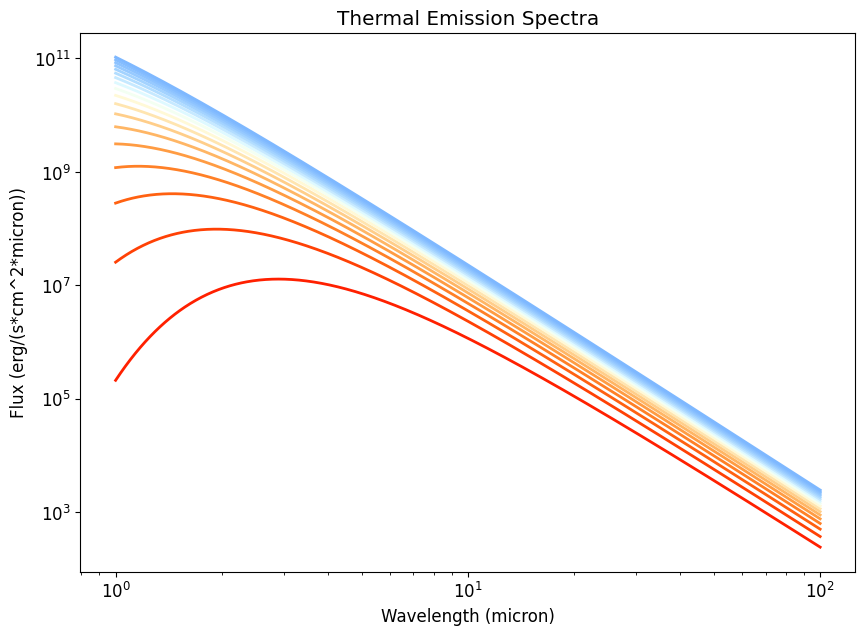

In [9]:
temps = np.arange(1000, 10000, 500)

for temp in temps:
    color = temperature2color(temp*units.K)
    flux = planck_flux(w, temp*units.K)
    plt.plot(w, flux, color=color, linewidth=2, label=f'{temp:.0f} K')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Wavelength (micron)')
    plt.ylabel('Flux (erg/(s*cm^2*micron))')
    plt.title('Thermal Emission Spectra')

<font color='seagreen'>
Note: there are no green stars! 

### Q3: A protoplanetary disk SED

In HW1, we considered a toy model of a protoplanetary disk: a flat disk that absorbs all the light that hits it and re-radiates that energy as a black body. We derived the temperature profile of the disk:

$T_{disk} =  T_* {\left(\frac{2}{3\pi}\right)}^{1/4} {\left(\frac{R_*}{r}\right)}^{3/4} $

Now, we'll create a cartoon spectral energy distribution (SED) of a protoplanetary disk. The SED is $\lambda F_\lambda$. In this cartoon, the total wavelength-dependent flux is

$$F_\lambda = F_{\lambda, star} + F_{\lambda, disk}$$

where $F_{\lambda, star}$ is the blackbody of the star and $F_{\lambda, disk}$ is blackbody spectrum of the disk. We calculated $F_{\lambda, star}$ on the first day of class:

$$F_{\lambda, star} = \pi B_\lambda(T_{*})\left(\frac{R_*}{D}\right)^2$$

where $T_{*}$ is the stellar temperature, and $B_\lambda(T_{*})$ is the Planck function (an intensity) at that temperature.

$F_{\lambda, disk}$ is trickier. We have a smooth disk which we will assume to extends from $R_{in}$ to $R_{out}$, where each radius contributes a unique blackbody function. As you'll see in the first homework, we can write:

$$dF_{\lambda, disk}(r) = B_\lambda(T_{disk}(r))\frac{2\pi r}{D^2}\cos{i}dr$$

where $T_{disk}$ is the disk temperature as stated above, $i$ is the inclination of the disk ($i=0$ corresponds to face-on) and $D$ is the distance between the observer and the disk.



In [10]:
def star_sed(wavelength, tstar, rstar, distance):
    '''
    This function takes the properties of the star and returns the SED of 
    the star.
    '''

    ## CODE GOES HERE
    star_sed = planck_flux(wavelength, tstar) * (rstar/distance)**2
    
    return star_sed.to('erg/(s*cm^2*micron)')


def disk_temperature(radius, tstar, rstar):
    '''
    This function takes the properties of the star and returns the disk
    temperature at the given radius.
    '''

    ## CODE GOES HERE
    tdisk = tstar * (2/(3*np.pi))**0.25 * (rstar/radius)**0.75

    return tdisk

    
def dflux_annulus(wavelength, radius, rstar, tstar, distance, inclination):
    '''
    This function takes a disk radius (which must have astropy units of _ 
    and the constant disk parameters D and i, and returns dFlux: the 
    contribution of this particular annulus of the disk to the total flux.
    The contribution is calculated separately for each inout wavelength.
    '''

    ## CODE GOES HERE
    tdisk = disk_temperature(radius, tstar, rstar)

    dflux = planck_intensity(wavelength, tdisk) * (2 * np.pi * radius * np.cos(inclination) / distance**2)

    # If you did this the way I did, awkwardly, we've converted the 
    # steradians into a ratio of lengths (those units cancel) but 
    # astropy still has the steradian hanging around and we have to get 
    # rid of it, which I did as follows:

    return dflux*(1*units.steradian)

def integrated_disk_sed(wavelength, rstar, tstar, 
                         distance, inclination,
                         r_in=6, r_out=2.3e4):
    
    # an array of radii at which to compute disk fluxes
    radii = np.logspace(np.log10(r_in),np.log10(r_out),1000)*units.R_sun
    
    # empty disk flux at each radius, to fill in
    dflux_array = np.zeros( (len(wavelength),len(radii)) )
    
    ## CODE GOES HERE
    for i, radius in enumerate(radii):
        this_flux = dflux_annulus(wavelength, radius.to('cm'), rstar, tstar, distance, inclination)
        dflux_array[:, i] = this_flux.value
    
    # units got lost when filling in the array if you did it the way I did
    dflux_array = dflux_array*this_flux.unit

    ## CODE GOES HERE
    disk_sed = simps(dflux_array.value, radii.value, axis=1) * dflux_array.unit * units.cm

    return disk_sed.to('erg/(s*cm^2*micron)') 
    

+ For the parameters below (typical for a young Sun), what is the temperature of the disk at a radius of 10 Rsun?

In [11]:
tstar = 4000*units.K
rstar = 2.5*units.R_sun
radius =  10*units.R_sun

In [12]:
temp_disk = disk_temperature(radius, tstar, rstar)
print(f'The disk temperature at {radius} is {temp_disk:.1f}')

The disk temperature at 10.0 solRad is 959.9 K


+ For the parameters below, plot the stellar and protoplanetary disk spectra separately, then overplot the combined spectrum. Make sure to label your axes and include a legend.

In [13]:
tstar = 4000*units.K
rstar = 2.5*units.R_sun
distance = 10*units.pc
inclination = 0*units.degree

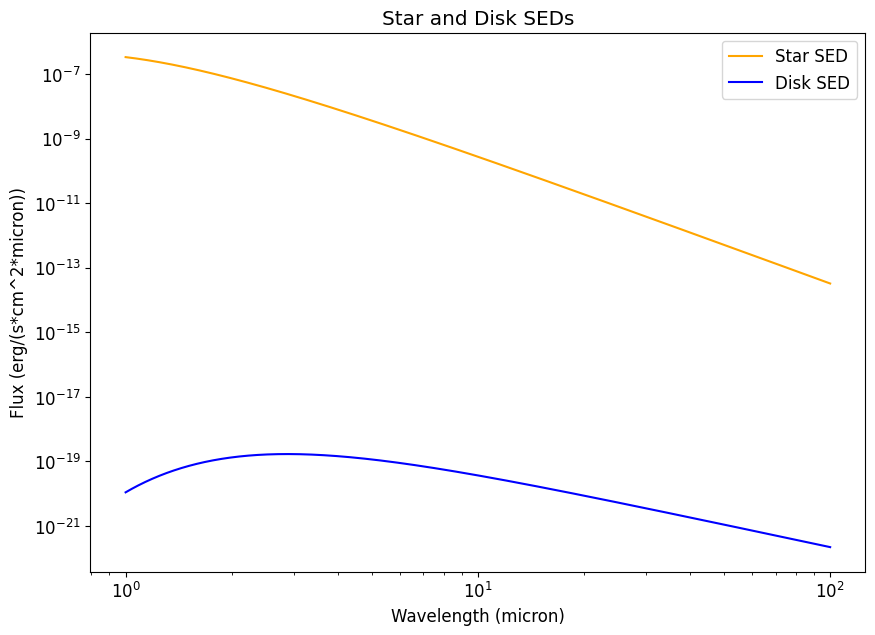

In [14]:
disk_sed_result = integrated_disk_sed(w, rstar.to('cm'), tstar, distance.to('cm'), inclination)
star_sed_result = star_sed(w, tstar, rstar.to('cm'), distance.to('cm'))

plt.plot(w, star_sed_result, label='Star SED', color='orange')
plt.plot(w, disk_sed_result, label='Disk SED', color='blue')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Wavelength (micron)')
plt.ylabel('Flux (erg/(s*cm^2*micron))')
plt.title('Star and Disk SEDs')
plt.legend()

<font color='seagreen'>
We did pretty well! (See, e.g. Figures 6 and 7 here: https://iopscience.iop.org/article/10.1088/0004-637X/700/2/1502#apj308794f6). As it turns out, most disks have stronger slopes to their SED than our model. This can be resolved if a disk is flared. The flared outer disk has a larger surface area and therefore absorbs more flux, which it then emits farther into the infrared.

+ If a disk as a gap in it (like these ones: https://aasnova.org/2018/11/16/the-origin-of-gaps-in-protoplanetary-disks/) what would be the impact on the SED?

<font color='seagreen'>
Emission increases when the disk has a gap because more of the stars radiation is able to reach far out gas in the disk.

+ Adapt the code above to simulate the SED of a disk with a gap in it.

In [15]:
def integrated_disk_gap_sed(wavelength, rstar, tstar, 
                         distance, inclination,
                         r_in=6, r_gap_in=200, r_gap_out=1000, r_out=2.3e4):
    
    # an array of radii at which to compute disk fluxes
    inner_radii = np.logspace(np.log10(r_in), np.log10(r_gap_in), 500) * units.R_sun
    outer_radii = np.logspace(np.log10(r_gap_out), np.log10(r_out), 500) * units.R_sun
    radii = np.concatenate([inner_radii, outer_radii])
    
    # empty disk flux at each radius, to fill in
    dflux_array = np.zeros( (len(wavelength),len(radii)) )
    
    ## CODE GOES HERE
    for i, radius in enumerate(radii):
        this_flux = dflux_annulus(wavelength, radius.to('cm'), rstar, tstar, distance, inclination)
        dflux_array[:, i] = this_flux.value
    
    # units got lost when filling in the array if you did it the way I did
    dflux_array = dflux_array*this_flux.unit

    ## CODE GOES HERE
    disk_sed = simps(dflux_array.value, radii.value, axis=1) * dflux_array.unit * units.cm

    return disk_sed.to('erg/(s*cm^2*micron)') 